In [9]:
import sys, os
from dotenv import load_dotenv
import numpy as np
from numpy import log, exp, sqrt
import pandas as pd
import wrds
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
WRDS_USER = os.getenv('PGUSER')
WRDS_PASS = os.getenv('PGPASSWORD')

conn = wrds.Connection()

Loading library list...
Done


In [10]:
ticker = 'TSLA'
start_date = '12/20/2019'
end_date = '12/23/2023'

df = conn.raw_sql(
    f"select returns.date, returns.vol as volume, returns.ret as return \
    from crsp.dsenames as meta, crsp.dsf as returns \
    where returns.date >= '{start_date}' and returns.date < '{end_date}' \
    and returns.date >= meta.namedt and returns.date < meta.nameendt \
    and meta.ticker = '{ticker}' and meta.permno = returns.permno", date_cols=['date']
)

In [11]:
# num. days for moving average window
n_days = 20
# min. pct. that daily volume is above n_days day volume SMA
volume_breakout_thresh = 0.75
# min. pct. stock is up on day of volume breakout
change_thresh = 0.05

df['signal'] = (
    (df['volume'] > (1+volume_breakout_thresh) * df['volume'].rolling(window=n_days).mean()) & \
    (df['return'] > change_thresh)
).astype(int).shift(1)

df = df.iloc[n_days:]

# number of days investment held
holding_period = 10

for idx in df[df['signal'] == 1].index:
    df.loc[idx: idx+holding_period-1, 'signal'] = 1

In [12]:
df['strategy_return'] = (1 + (df['return'] * df['signal'])).cumprod() - 1

In [13]:
years = (df['date'].max() - df['date'].min()).total_seconds() / (60*60*24*252)

ret = (1 + df['strategy_return']).iloc[-1]
cagr = ret**(1/years)

'Total return: %.2f%%, CAGR: %.2f%%' % ((ret - 1)*100, (cagr - 1)*100)

'Total return: 34.53%, CAGR: 5.37%'

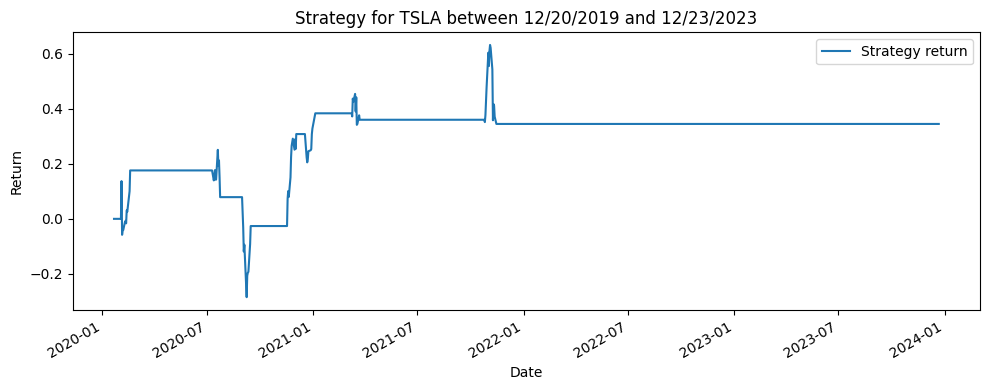

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.lineplot(data=df, x='date', y='strategy_return', label='Strategy return')
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax.set_title(f'Strategy for {ticker} between {start_date} and {end_date}')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Sandbox

In [21]:
df

,date,volume,return,signal,strategy_return
20,2020-01-22,31246840.0,0.040863,0.0,0.000000
21,2020-01-23,19647957.0,0.004635,0.0,0.000000
22,2020-01-24,14307966.0,-0.012898,0.0,0.000000
23,2020-01-27,13573672.0,-0.012039,0.0,0.000000
24,2020-01-28,11790607.0,0.015913,0.0,0.000000
...,...,...,...,...,...
1004,2023-12-18,116089652.0,-0.005602,0.0,0.345342
1005,2023-12-19,106287817.0,0.020390,0.0,0.345342
1006,2023-12-20,124527509.0,-0.039188,0.0,0.345342
1007,2023-12-21,109157466.0,0.029781,0.0,0.345342
